# Introduction

The authors of the paper "Transport map accelerated Markov chain Monte Carlo" [1] propose a new framework that combines transport of measure maps with the Metropolis-Hastings rule to generate non-Gaussian proposal distributions that can more effectively explore the target density.
Their method constructs a lower triangular transport map, which approximates the Knothe-Rosenblatt rearrangement, using information from previous MCMC states. This is achieved through the solution of a convex and separable optimization problem, which enables efficient and parallelizable adaptation of the map even for large numbers of samples.
The authors demonstrate that their approach produces an adaptive MCMC algorithm that is ergodic for the exact target distribution, even when using inexact or truncated maps. Their numerical experiments show that their method can produce order-of-magnitude speedups over standard MCMC techniques. 

Our study conducted an examination of the main algorithm for efficient sampling from complex probability distributions, the underlying optimization problem that guides its design, and reformulations aimed at enhancing its computational efficiency, which also included a small exploration of transport theory.

[1] Parno Matthew and Marzouk Youssef. “Transport map accelerated Markov chain
Monte Carlo”. In: (Dec. 2014). arXiv: 1412.5492 [stat.CO].

**Remark:** a PDF version of this document is available. We recommend using it to focus on the theory and algorithm explanations.

# Transport map
Since the paper we studied heavily depends on the concept of transport maps, it is crucial to define this notion and outline the necessary properties required for the transport map MCMC algorithm.

**Transport map:** Given two probability measures, $\mu$ and $\nu$, defined on $\mathbb{R}^d$. A Borel map, $T: \mathbb{R}^d \to \mathbb{R}^d$, is considered a transport map between $\mu$ and $\nu$ if it satisfies the equality $\mu(T^{-1}(B)) = \nu(B)$ for every Borel set $B$. This is denoted as $T_{\#}\mu = \nu$, representing the pushforward of $\mu$. The set of all transport maps between $\mu$ and $\nu$ is denoted as $\mathcal{T}(\mu, \nu)$.

*Example:*  Lets consider $\mu, \nu \in \mathbb{P}(\mathbb{R})$ with: $\mu = \delta_0$ and $\nu = \frac 12\delta_1 + \frac 12 \delta_2$. 
We have: $\mathcal{T}(\mu, \nu) = \emptyset$ but $\mathcal{T}(\nu, \mu) = \{ T: \text{Borel map}; T(1) = T(2) = 0\}$.
With this example, we see that $\mathcal{T}(\mu, \nu)$ can be empty or can contain infitintely many Borel maps. We also see that in general: $\mathcal{T}(\mu, \nu) \neq \mathcal{T}(\nu, \mu)$. 

**Notation:** For the study of our article, we focus on $\mu, \nu \in \mathbb{P}(R^d)$ two absolutely continuous probabilities wrt the Lebesgue measure. We note there densities $\rho: \mathbb{R}^d \to \mathbb{R}^+$ resp. $\pi : \mathbb{R}^d \to \mathbb{R}^+$. 

**Remark:** given $T \in \mathcal{T}(\mu, \nu)$ by the change-of-variables formula, we have: 
$$
    \rho \circ T^{-1}(x) \det |\nabla T^{-1}(x)| = \pi(x) := T_\#\rho(x) 
$$
supposing $\rho, \pi$ and $T$ to be regular enough and that such a $T$ exists. 

## Knothe-Rosenblatt rearrangement
As a special case of transport map between two measures, we will focus here on the Knothe-Rosenbaltt rearrangement or simply Knothe transport. This transport map will be usefull in a minimization problem that we will define later on. More details on this transport map can be find in [2]. 

First of all, we need to define the **increasing rearrangement formula**: Given $\mu, \nu \in \mathbb{P}(R^d)$ with cumulative distribution functions $F$ resp. $G$ and their right continuous inverses $F^{-1}$ resp $G^{-1}$, we define : 
$$T = G^{-1}\circ F$$
when $\mu$ is atomless, we have $T_\#\mu = \nu$ and it's an increasing transport map. 

Now, we can define and construct the Knothe-Rosenblatt rearrangement:
By the increasing formula, we define $y_1 = T_1(x_1)$ by the increasing rearrangement formula of $\mu_1$ into $\mu_1$.
Then, for $1 < i \leq d$, we take the marginal on the first $i$ variables and use the conditional probability formula:
$$
\begin{aligned}
\mu_i(dx_1 \cdots dx_i) &= \mu_{i-1}(dx_1 \cdots dx_{i-1})\mu_i(dx_i|x_1,\cdots,x_{i-1})\\ 
\nu_i(dy_1 \cdots dy_i) &= \nu_{i-1}(dy_1 \cdots dy_{i-1})\nu_i(dy_i|y_1,\cdots,y_{i-1}).
\end{aligned}
$$

Next, we set $y_1=T_1(x_1)$ and define $y_i=T_i(x_i;x_1,\cdots,x_{i-1})$ by the increasing rearrangement formula of $\mu_i(dx_i|x_1,\cdots,x_{i-1})$ into $\nu_i(dy_i|y_1,\cdots,y_{i-1})$.
Finally, we set $T(x) = (y_1,\cdots,y_n)$ to have the Knothe-Rosenblatt rearrangement.

By construction of the Knothe transport $T$, we have that $T_\#\mu = \nu$ and its Jacobian is upper triangular with positive entries on the diagonal.

[2] Santambrogio F. Optimal Transport for Applied Mathematicians. Calculus of Vari-
ations,PDEs, and Modeling. isbn: 9783319208282.

# Transport map MCMC
## MCMC with a fixed transport map
Here, we suppose that with have a lower triangular transport map $S$ such that $S_\#\nu \simeq \mu$, with the reference measure $\mu$ being a standard Gaussian. We will use this map in order to make a modified version of Metropolis-Hastings using this transport map.

The transport map makes it straightforward to evaluate this map, as $\theta' = S^{-1}(r')$ and $\theta^{(k)} = S^{-1}(\theta^{(k)})$. With the transport map, the loop in the Metropolis-Hastings algorithm proceeds as follows:

**Fixed transport map MCMC:**

For $k = 1$ to $K-1$:
 
- Compute the reference state: $r^{(k)} = S(\theta^{(k)})$
- Sample from the reference proposal: $r' \sim q_r(\cdot | r^{(k)})$
- State Compute the target proposal: $\theta' = S^{-1}(r')$
- State Accept the new proposal with probability $\alpha$

If *the proposal is accepted*:
- $\theta^{(k+1)} \leftarrow \theta'$

Else:

- $\theta^{(k+1)} \leftarrow \theta^{(k)}$

The lower triangular structure of our map $S$ facilitates computation of its inverse. Inverting $S$ involves solving $d$ one-dimensional inversion problems. For instance, each of these problems can be efficiently solved using Newton's algorithm.


## Adaptative transport map MCMC
Even though presenting MCMC with a fixed transport map was revelant in order to understand the main idea of this modified Metropolis Hastings algorithm, we don't have such a map in practice. Indeed, to construct a map $T$ such that $T_\#\nu \simeq \mu$ we need in practive  $(\theta^{(1)}, \cdots, \theta^{(K)})$ samples from our target distribution $\nu$. To do so, the algorithm proposed is adapting the transport map $T$ when new samples $(\theta'^{(1)}, \cdots, \theta'^{(K)})$ are given. We can translate the algorithm as followed:

**Adptative transport map MCMC:**

$T_0 \gets \text{Identity}$

Generate initial samples using $T_0$
For $k \gets 1$ to $N_{loops}$
- FixedTransportMCMC($T_K$)
- generate new samples using the fixed transport map and accept/reject criteria
- State estimate a new transport map $T_{K+1}$ using the new samples

Return: samples


## Optimisation problem
Having explored the adaptation of the Metropolis-Hastings algorithm to incorporate a transport map, we now turn to the construction of such a map. To begin, we define the set over which we will operate to approximate a transport map.

A Borel map $T: \mathbb{R}^d \to \mathbb{R}^d$ is said to be lower triangular if: 
$T(x) = [T_1(x_1), T_2(x_1,x_2), \dots, T_d(x_1, \dots, x_d)]^T$.

We set:
$\mathcal{T}_{\triangle} := \left\{ T \text{ lower triangular, strictly increasing with } T \text{ and differentiable everywhere} \right\}$.

While the Knothe-Rosenblatt rearrangement belongs to $\mathcal{T}_\triangle \cap \mathcal{T}(\mu, \nu)$, it can be computationally challenging to work with. Instead, we aim to approximate the pushforward equality $T\in \mathcal{T}_{\triangle}$ and $T_\#\mu \simeq \nu$. To accomplish this, we leverage the Kullback-Leibler divergence to quantify the similarity between our two probability densities and formulate a corresponding minimization problem:
$$
    \displaystyle \underset{T \in \mathcal{T}_\triangle(\mu) }{\text{arg min }} D_{KL}(\nu||T_\#\mu)
$$
Thanks to the Knothe transport, we know that the minimum of this Kullback-Leibler divergence is $0$ on this set. 

Given that $T_\#\mu = \rho \circ T^{-1}(x) \det |\nabla T^{-1}(x)|$ this is equivalent to
$$
    \displaystyle \underset{T \in \mathcal{T}_\triangle(\mu) }{\text{arg min } }\mathbb{E}_\nu\left[-\log \rho\circ T^{-1}(x) - \log|\det \nabla T^{-1}(x)| \right]
$$

**Remark:** in what follows, we will replace $T^{-1}$ with $S$. Usually, we refer as $T$ a if it is in $\mathcal{T}(\mu, \nu)$, and $S$ if it is in $\mathcal{T}(\nu, \mu)$. It doesn't change the problem since the inverse is unique and it's more readable.

Making the optimization problem easier}
Now that we have set our optimization problem, we would like to make it computationnaly easier to solve. Suppose that we have $(x^{(1)}, \dots , x^{(K)})$ $\overset{\text{iid}}{\sim} \mu$, we can approximate our problem: 
$$
    \displaystyle \underset{S \in \mathcal{T}_\triangle(\mu) }{\arg \min} \frac 1K\underset{k=1}{\overset{K}{\sum}}\left[-\log \rho\circ S(x^{(k)}) - \log|\det \nabla S(x^{(k)})|  \right]
$$
Then, by choosing $\mu \sim \mathcal{N}(0, I)$ and knowing that $T \in \mathcal{T}_\nabla$, we have an easy formula for $\log \rho(x)$ and the Jacobian that leads to:

$$
    \displaystyle \underset{S \in \mathcal{T}_\triangle(\mu) }{\arg \min}\left [ \underset{i=1}{\overset{n}\sum} \underset{k=1}{\overset{K}{\sum}}\frac 12 (S_i(x^{(k)})^2 - \log \frac{\partial S_i}{\partial x_i}(x^{(k)})\right ]
$$

In order to make each $S_i$ inversible, we need to assure that for all $k$:
$$
    \displaystyle \frac{\partial S_i(\theta^{(k)})}{\partial \theta_i} > 0
$$
We add this constraint into $\mathcal{T}_\triangle$ without changing the space name. 
We will not discuss more details on the conditions for the map $S$ that are necessary to proove the ergodicity of the algorithm proposed in the article. Nevertheless, we can notice that the conditions on the map $S$ and the formulation above lead to a seprable optimisation problem over the dimension and that each problem is convex on a closed feasible domain. We refer to the article for more details.

### Map parametrization
With equation (7), we have a separable optimization problem. To solve it, the article proposes to reparametrize our maps. For example, we can reparametrize each map $S_i$ with a multivariate polynomial expension. 

As an example, lets take $\mu, \nu \in \mathbb{P}(\mathbb{R}^2)$ and the subsace $\mathbb{R}_2[X_1,X_2]$ of polynomials of $\mathbb{R}^2$ with a degree lower or equal to two. Each $P \in \mathbb{R}_2[X_1,X_2]$ is of the form: 
    $$P(X_1, X_2) = a_1X_1^2 + a_2X_2^2 + b_1X_1 + b_2X_2 + cX_1X_2 + d$$
with $a_1, a_2, b_1, b_2, c, d \in \mathbb{R}$. 
Each polynomial of $\mathbb{R}_2[X_1,X_2]$ can be identified with its coefficient $\gamma = (a_1, a_2, b_1, b_2, c, d)$.

With this family of functions, we have; 
$$
\begin{aligned}
    S_{\gamma_1,1}(X_1, X_2) &= a_{1,1}X_1^2 + b_{1,1}X_1 + c_1X_1X_2 +d\\
    S_{\gamma_2,2}(X_1, X_2) &= a_{1,2}X_1^2 + a_{2,2}X_2^2 + b_{1,2}X_1 + b_{2,2}X_2 + c_2X_1X_2 + d_2
\end{aligned}
$$

Where $\gamma_1 = (a_{1,1}, b_{1,1}, c_1)$ and $\gamma_2 = (a_{1,2},a_{2,2},b_{1,2},b_{2,2},c_2)$.
With this reparametrization, the optimization problem (7) becomes: 

$$
\begin{aligned}
    \displaystyle \underset{\gamma_1, \gamma_2 }{\arg \min}\left [ \underset{i=1}{\overset{n}\sum} \underset{k=1}{\overset{K}{\sum}}\frac 12 (S_{i,\gamma_i}(x^{(k)})^2 - \log \frac{\partial S_{i, \gamma_i}}{\partial x_i}(x^{(k)})\right ]
\end{aligned}
$$

### Code of the transport map

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import seaborn as sns
import random
random.seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')


In [2]:
# Here, we define the transport map, parametrized as 2d multinomalis T1 and T2
# We also define the cost function C1 and C2, which are the KL divergence approximation between T1 and T2 and N(0,1)
# We also define the inverse of T1 and T2, which is T_inv

def T1(params, X):
    """
    parameters:
    params: coefficients of the polynomial T1
    X: vector of size 2

    returns:
    T1(X[0]) = a * X[0]**2 + b * X[0] + c 
    """
    a, b, c = params
    if len(X.shape) == 1:  # 2D vector
        return a * X[0]**2 + b * X[0] + c
    elif X.shape[1] == 2:  # n*2 matrix
        return np.array(a * X[:,0]**2 + b * X[:,0] + c)
    else:
        raise ValueError("Invalid input shape for X")
def T2(params, X):
    """
    parameters:
    params: coefficients of the polynomial T2
    X: vector of size 2


    returns:
    T2(X[0], X[1])
    """
    a1, a2, b1, b2, c = params
    if len(X.shape) == 1:
        return a1 * X[0]**2 + a2 * X[1]**2 + b1 * X[0] + b2 * X[1] + c
    elif X.shape[1] == 2:
        return a1 * X[:,0]**2 + a2 * X[:,1]**2 + b1 * X[:,0] + b2 * X[:,1] + c
    else:
        raise ValueError("Invalid input shape for X")
        
def partial_T1(params, X):
    """ 
    parameters:
    params: coefficients of the polynomial T1
    X: vector of size 2

    returns:
    \partial T1(X[0]) / \partial X_1
    """
    a, b, c = params
    return np.array(2 * a * X[:,0] + b*np.ones(len(X[:,0])))
def partial_T2(params, X):
    """ 
    parameters:
    params: coefficients of the polynomial T1
    X: vector of size 2

    returns:
    \partial T1(X[0]) / \partial X_2
    """
    a1, a2, b1, b2, c = params
    return np.array(2 * a2 * X[:,1] + b2*np.ones(len(X[:,1])))

def C1(params, X): 
    """ 
    parameters:
    params: coefficients of the polynomial T1
    X: vector of size 2

    returns:
    cost of the approximation KL between T1 and N(0,1) with samples X
    """  
    return 0.5*np.sum(T1(params, X)**2 - np.log(partial_T1(params, X)))

def C2(params, X):
    """ 
    parameters:
    params: coefficients of the polynomial T1
    X: vector of size 2

    returns:
    cost of the approximation KL between T1 and N(0,1) with samples X
    """  
    return 0.5*np.sum(T2(params, X)**2 - np.log(partial_T2(params, X)))

def min_max(X):
    """
    parameters:
    X: array of size n x 2

    returns:
    bounds: the min and max of X_1 and X_2
    """
    max_X_1 = np.max(X[:, 0])
    min_X_1 = np.min(X[:, 0])
    max_X_2 = np.max(X[:, 1])
    min_X_2 = np.min(X[:, 1])
    return np.array([min_X_1, max_X_1, min_X_2, max_X_2])

def T_inv(coeff_T1, coeff_T2, y, bounds):
    """ 
    parameters:
    coeff_T1: coefficients of T1
    coeff_T2: coefficients of T2
    y: output of T1 and T2
    bounds: bounds of the domain of T1 and T2

    returns:
    X: inverse of T1 and T2, vector of size 2
    """
    #root for x1: 
    a, b, c = coeff_T1
    c = c - y[0]
    roots = np.roots([a, b, c])
    root_1 = roots[0]
    # Check if roots are real
    if not np.isreal(roots).all():
        raise ValueError('Roots are not real')
    if roots[0] < bounds[0] or roots[0] > bounds[1]: # if root_1 is not in the domain
        root_1 = roots[1]
    
    #root for x2:

    a1, a2, b1, b2, c = coeff_T2

    a_0 = a2
    b_0 = b2
    c_0 = a1 * root_1**2 + b1 * root_1 + c - y[1]

    roots = np.roots([a_0, b_0, c_0])
    # Check if roots are real
    if not np.isreal(roots).all():
        raise ValueError('Roots are not real')
    if roots[0] < bounds[2] or roots[0] > bounds[3]: # if roots[0] is not in the domain
        return np.array([root_1, roots[1]])
    return np.array([root_1, roots[0]])

def min_max(X):
    """
    parameters:
    X: array of size n x 2

    returns:
    bounds: the min and max of X_1 and X_2
    """
    max_X_1 = np.max(X[:, 0])
    min_X_1 = np.min(X[:, 0])
    max_X_2 = np.max(X[:, 1])
    min_X_2 = np.min(X[:, 1])
    return np.array([min_X_1, max_X_1, min_X_2, max_X_2])

def optimize_parameters(X):
    """
    parameters:
    X: array of size n x 2

    returns:
    coeff_T1: coefficients of T1 optimized wrt to the KL divergence with N(0,I_2)
    coeff_T2: coefficients of T2 optimized wrt to the KL divergence with N(0,I_2)
    """
    bounds = min_max(X)

    #initial guess: 
    params0_c1 = np.array([0,1,0])
    params0_c2 = np.array([0,0,0,1,0])

    #counstraints: 

    #getting the bounds as global variables:
    min_X1, max_X1, min_X2, max_X2 = min_max(X)

    #def of the constraints:
    #for T1: 
    def constraint1(params):
        a,b,c = params 
        return 2*a*min_X1 + b -1e-5
    def constraint2(params):
        a,b,c = params 
        return 2*a*max_X1 + b -1e-5

    #for T2:
    def constraint3(params):
        a1,a2,b1,b2,c = params 
        return 2*a2*min_X2 + b2 -1e-5
    def constraint4(params):
        a1,a2,b1,b2,c = params 
        return 2*a2*max_X2 + b2 -1e-5


    cons1 = {'type': 'ineq', 'fun': constraint1}
    cons2 = {'type': 'ineq', 'fun': constraint2}
    cons3 = {'type': 'ineq', 'fun': constraint3}
    cons4 = {'type': 'ineq', 'fun': constraint4}

    constraints_c1 = [cons1, cons2]
    constraints_c2 = [cons3, cons4]  # Fixed the variable name here

    # Optimization
    result_c1 = minimize(C1, params0_c1, args=(X,), constraints=constraints_c1)
    result_c2 = minimize(C2, params0_c2, args=(X,), constraints=constraints_c2)

    return result_c1.x, result_c2.x

def generate_2d_gaussian_mixture(num_components = 3, n_samples = [1000,1000,1000]):
    #fixed for the comments to make sense
    means = [[ 1.78304649, -1.39014005], [ 5.72589728, -7.1879583 ], [-5.09949788,  5.78601833]]
    covs = [[[0.92179426, 0.],[0., 0.70733252]],
         [[1.76444733, 0.], [0., 1.65310297]], 
         [[1.45830941, 0],[0.        , 1.48383502]]]
    samples = [np.random.multivariate_normal(mean, cov, n) for mean, cov, n in zip(means, covs, n_samples)]
    gaussian_mixture = np.concatenate(samples, axis=0)
    return gaussian_mixture
    
def plot_mixture(mixture, title = "Gaussian mixture"):
    plt.scatter(mixture[:, 0], mixture[:, 1], alpha=0.5)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    plt.show()


def plot_histograms(data, title = "Histograms of Components", ax=None):
    """
    data : samples of the distribution 

    returns:
    Plots histograms of the two components of the data.
    """
    component_1 = data[:, 0]
    component_2 = data[:, 1]

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.hist(component_1, bins=30, alpha=0.75, label="Component 1")
    ax.hist(component_2, bins=30, alpha=0.75, label="Component 2")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.set_title(title)


def plot_density_approx(data, title="Kernel Density Estimation of Components", ax=None):
    """
    data : samples of the distribution 

    returns:
    Plots KDEs of the two components of the data.
    """
    component_1 = data[:, 0]
    component_2 = data[:, 1]

    if ax is None:
        fig, ax = plt.subplots()
    
    sns.kdeplot(component_1, label="Component 1", ax=ax)
    sns.kdeplot(component_2, label="Component 2", ax=ax)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_title(title)



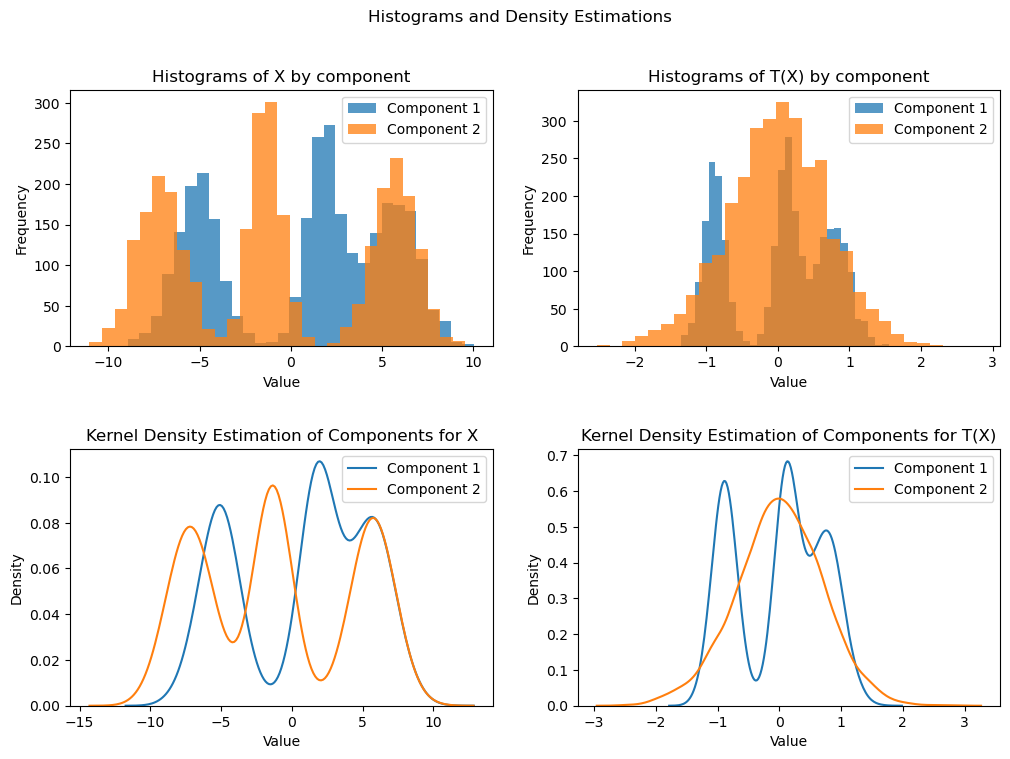

In [3]:
#parameters for our random gaussian mixture:
num_components = 3
n_samples = [1000, 1000, 1000]
mean_range = (-10, 10)
cov_range = (0.5, 2)

#generation of our random gaussian mixture:
X = generate_2d_gaussian_mixture(num_components, n_samples)

#find the best triangular transformation with degree 2 polynomials:
coeff_T1, coeff_T2 = optimize_parameters(X)
Y = np.array([[T1(coeff_T1, X[i,:]), T2(coeff_T2, X[i,:])] for i in range(len(X))])

# Create the figure with histograms and densities 
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Histograms and Density Estimations")

ax1 = fig.add_subplot(2, 2, 1)
plot_histograms(X, title="Histograms of X by component", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
plot_histograms(Y, title="Histograms of T(X) by component", ax=ax2)

ax3 = fig.add_subplot(2, 2, 3)
plot_density_approx(X, title="Kernel Density Estimation of Components for X", ax=ax3)

ax4 = fig.add_subplot(2, 2, 4)
plot_density_approx(Y, title="Kernel Density Estimation of Components for T(X)", ax=ax4)

plt.subplots_adjust(hspace=0.4)

plt.show()


Just above is an example with a 2D gaussian mixture

The transformation resulted in a density that is much more similar to a Gaussian distribution. Specifically, the second component changed from a trimodal to unimodal distribution, while the variability in the first component decreased. Although a higher degree polynomial could provide a more accurate approximation, the partial derivative constraints restrict the $T_1$ function to almost linear behavior, even with a degree 3 polynomial.

It is clear that we can extend this example to higher dimensions by increasing the maximum degree of our multivariate polynomials or by using alternative bases such as orthogonal polynomials like Hermite or Legendre polynomials. An optimal choice of basis would be one that results in linear $S_i$ maps with respect to the expansion coefficients $\gamma_i$, as recommended in the paper. This property improves the efficiency of solving the minimization problem (1), further details can be found in the article.

# Experimenting the algorithm

## Transport map
In our experiments, we choosed to approximate our transport map with 2 degree polynomials like in section 3.3.2. We will illustrate here the modification applied to a 2D mixture of three gaussians with a transport map minimizing (11). 

Our focus now is to examine the practical effectiveness of accelerating MCMC using transport maps. Our approach involves utilizing the Metropolis-Hastings algorithm and comparing it with the transport map variant. It's worth noting that transport maps can also be applied to other MCMC algorithms, such as Langevin Monte Carlo, making it a versatile tool.

Our example target distribution is the following two dimension gaussian mixture: 
\begin{align}
    \frac13 \mathcal{N}([-3,0], I_2) + \frac13 \mathcal{N}([3,0], I_2) + \frac13 \mathcal{N}([0,3], I_2)
\end{align}
Although the target distribution is not particularly difficult, we will observe that the MH algorithm struggles to sample from it. Additionally, using a 2D example is advantageous for visualizing the problem, as increasing the number of dimensions would complicate our understanding.

For instance, here is what this target distribution looks like:

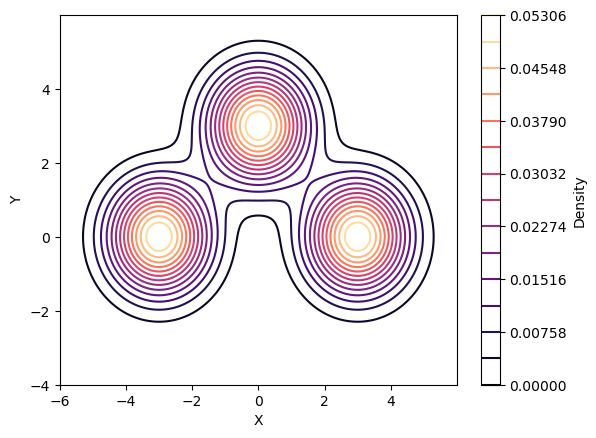

In [4]:
def sample_gaussian_mixture(num_samples, means, covariances, weights):
    num_components = len(weights)
    samples = []

    for _ in range(num_samples):
        component = np.random.choice(num_components, p=weights)
        sample = np.random.multivariate_normal(means[component], covariances[component])
        samples.append(sample)

    return np.array(samples)


means = [np.array([-3, 0]), np.array([3, 0]), np.array([0, 3])]
covariances = [np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]])]
weights = [1/3, 1/3, 1/3]

# Sample points from the Gaussian mixture
num_samples = 10000
samples = sample_gaussian_mixture(num_samples, means, covariances, weights)

x, y = np.mgrid[-6:6:.01, -4:6:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

z = np.zeros(x.shape)
for mean, cov, weight in zip(means, covariances, weights):
    z += weight * multivariate_normal(mean, cov).pdf(pos)

levels = np.linspace(z.min(), z.max(), 15)
plt.contour(x, y, z, levels=levels, cmap= 'magma')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Density')
plt.show()

We can also have  alook on the map transformation used to make the target distribution closer to our source distriubtion, using 1000 samples from it tu have $T_\#\nu \simeq \mu$ for the KL divergence. 

# Comparing the algorithms

In our experiments, we choosed to approximate our transport map with 2 degree polynomials like in section 3.3.2. We will illustrate here the modification applied to a 2D mixture of three gaussians with a transport map minimizing (11). 

Our focus now is to examine the practical effectiveness of accelerating MCMC using transport maps. Our approach involves utilizing the Metropolis-Hastings algorithm and comparing it with the transport map variant. It's worth noting that transport maps can also be applied to other MCMC algorithms, such as Langevin Monte Carlo, making it a versatile tool.

Our example target distribution is the following two dimension gaussian mixture: 
\begin{align}
    \frac13 \mathcal{N}([-3,0], I_2) + \frac13 \mathcal{N}([3,0], I_2) + \frac13 \mathcal{N}([0,3], I_2)
\end{align}
Although the target distribution is not particularly difficult, we will observe that the MH algorithm struggles to sample from it. Additionally, using a 2D example is advantageous for visualizing the problem, as increasing the number of dimensions would complicate our understanding.

## MH algorithm

Even though this toy example is not really complex, the usual MH algorithms isn't really.
With 1000 samples, we can see that MH approximates really poorly our distribution. 

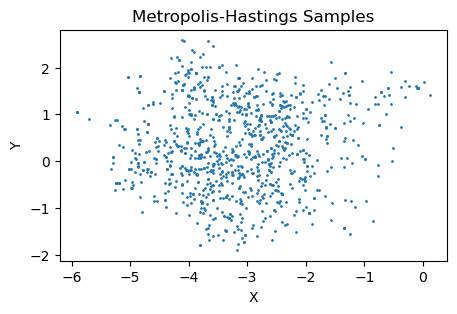

In [66]:
## MH algorithm functions
def multivariate_gaussian_pdf(x, mean, cov):
    # Define the target probability density function (PDF)
    dim = len(x)
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    x_diff = x - mean
    exponent = -0.5 * x_diff.T @ inv_cov @ x_diff

    return np.exp(exponent) / np.sqrt((2 * np.pi) ** dim * det_cov)

def target_pdf(theta):
    # Define the Gaussian mixture components
    means = [np.array([-3, 0]), np.array([3, 0]), np.array([0, 3])]
    covariances = [np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]])]
    weights = [1/3, 1/3, 1/3]

    # Calculate the weighted sum of the Gaussian components
    pdf_value = 0
    for i in range(3):
        pdf_value += weights[i] * multivariate_gaussian_pdf(theta, means[i], covariances[i])

    return pdf_value

def proposal_distribution(current_position, proposal_covariance):
    # Proposal distribution: 2D Gaussian centered at the current position with a given covariance matrix
    return np.random.multivariate_normal(current_position, proposal_covariance)

def metropolis_hastings(target_pdf, proposal_distribution, proposal_covariance, num_samples, initial_position):
    # Metropolis-Hastings algorithm
    current_position = initial_position
    samples = []

    for _ in range(num_samples):
        proposal = proposal_distribution(current_position, proposal_covariance)
        pdf_current = target_pdf(current_position)
        pdf_proposal = target_pdf(proposal)

        acceptance_ratio = pdf_proposal / pdf_current

        if np.random.rand() < acceptance_ratio:
            current_position = proposal

        samples.append(current_position)

    return np.array(samples)


# Parameters for the algorithm
num_samples = 1000
initial_position = np.array([0, 0])
proposal_covariance = np.array([[0.1, 0], [0, 0.1]])

# Run Metropolis-Hastings
samples = metropolis_hastings(target_pdf, proposal_distribution, proposal_covariance, num_samples, initial_position)

# Visualize the samples
plt.figure(figsize=(5, 3)) 
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Metropolis-Hastings Samples')
plt.show()


As we can see, 1000 samples aren't enough for the MH algorithm to converge and the result is a really bad approximation of our mixture. 

## MH with transport map
We fix our source measure to $\nu = \mathcal{N}(0_2, I_2)$.
Here, we suppose that we already have a map $T$ such that $T_\#\nu \simeq \mu$. To do so, we already generated samples from $\nu$ and optimized our approximation $T$. We will adapt the MH algorithm to make use of our transport map.

First of all, let's visualize our map $T$:

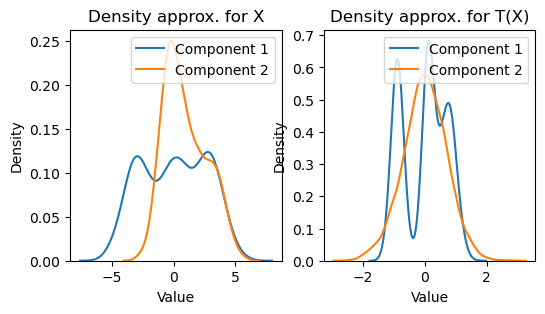

In [6]:
means = [np.array([-3, 0]), np.array([3, 0]), np.array([0, 3])]
covariances = [np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]])]
weights = [1/3, 1/3, 1/3]

# Sample points from the Gaussian mixture
num_samples = 1000
X = sample_gaussian_mixture(num_samples, means, covariances, weights)

#Find the transport map
coeff_T1, coeff_T2 = optimize_parameters(X)

#visualize the transport map and the samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

plot_density_approx(X, title="Density approx. for X", ax=ax1)
plot_density_approx(Y, title="Density approx. for T(X)", ax=ax2)

plt.show()

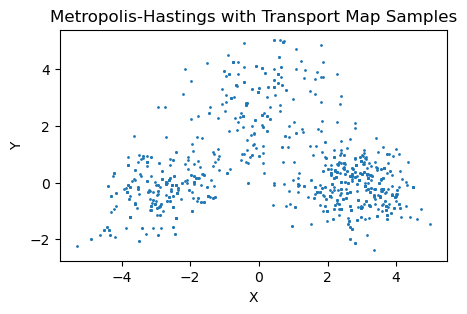

In [7]:
def multivariate_gaussian_pdf(x, mean, cov):
    dim = len(x)
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    x_diff = x - mean
    exponent = -0.5 * x_diff.T @ inv_cov @ x_diff

    return np.exp(exponent) / np.sqrt((2 * np.pi) ** dim * det_cov)

def target_pdf(theta):
    # Define the Gaussian mixture components
    means = [np.array([-3, 0]), np.array([3, 0]), np.array([0, 3])]
    covariances = [np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]])]
    weights = [1/3, 1/3, 1/3]

    # Calculate the weighted sum of the Gaussian components
    pdf_value = 0
    for i in range(3):
        pdf_value += weights[i] * multivariate_gaussian_pdf(theta, means[i], covariances[i])

    return pdf_value

# Define the transport map and its inverse
def S(theta, coeff_T1, coeff_T2):
    return np.array([T1(coeff_T1, theta), T2(coeff_T2, theta)])

def S_inv(r, coeff_T1, coeff_T2, bounds):
    return T_inv(coeff_T1, coeff_T2, r, bounds)

# Define the gradient of the transport map
def det_grad_S(theta, coeff_T1, coeff_T2):
    a, b, c = coeff_T1
    partial_T1 = 2*a*theta[0] + b
    a1, a2, b1, b2, c = coeff_T2
    partial_T2 = a2*theta[1] + b2
    return np.abs(partial_T1 * partial_T2)

# Define the reference proposal distribution
def reference_proposal(r, proposal_covariance):
    return np.random.multivariate_normal(r, proposal_covariance)


# Modified Metropolis-Hastings algorithm using the transport map
def metropolis_hastings_with_transport_map(target_pdf, coeff_T1, coeff_T2, bounds, S, S_inv, reference_proposal, proposal_covariance, num_samples, initial_position):
    theta_current = initial_position
    samples = []

    for _ in range(num_samples):
        try: 
            r_current = S(theta_current, coeff_T1, coeff_T2)
            r_proposal = reference_proposal(r_current, proposal_covariance)
            theta_proposal = S_inv(r_proposal, coeff_T1, coeff_T2, bounds)

            pdf_current = target_pdf(theta_current)
            pdf_proposal = target_pdf(theta_proposal)

            def multivariate_gaussian_pdf(x, mean, cov):
                dim = len(x)
                inv_cov = np.linalg.inv(cov)
                det_cov = np.linalg.det(cov)
                x_diff = x - mean
                exponent = -0.5 * x_diff.T @ inv_cov @ x_diff

                return np.exp(exponent) / np.sqrt((2 * np.pi) ** dim * det_cov)

            q_current_to_proposal = multivariate_gaussian_pdf(r_proposal, r_current, proposal_covariance) * det_grad_S(theta_proposal, coeff_T1, coeff_T2)
            q_proposal_to_current = multivariate_gaussian_pdf(r_current, r_proposal, proposal_covariance) * det_grad_S(theta_current, coeff_T1, coeff_T2)

            acceptance_ratio = np.min([1, (pdf_proposal * q_proposal_to_current) / (pdf_current * q_current_to_proposal)])

            if np.random.rand() < acceptance_ratio:
                theta_current = theta_proposal

            samples.append(theta_current)
        except:
            pass

    return np.array(samples)

# Parameters for the algorithm
num_samples = 1000
initial_position = np.array([0, 0])
proposal_covariance = np.array([[0.1, 0], [0, 0.1]])
bounds = min_max(X)


# Run Metropolis-Hastings with a fixed transport map
samples = metropolis_hastings_with_transport_map(target_pdf, coeff_T1, coeff_T2, bounds, S, S_inv, reference_proposal, proposal_covariance, num_samples, initial_position)

# Visualize the samples
plt.figure(figsize=(5, 3)) 
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Metropolis-Hastings with Transport Map Samples')
plt.show()


As we can see, even thoug our transport map isn't a really accurate approximation in order to make $T_\#\nu$ similare to a gaussian, the samples with the transport map proposals are way better than for the classing MH algorithm. 

# Addaptative transport map MH

We we will implement the main algorithm of the paper we studied. In this algorithm, we start with the normal MH algorithm and each K steps, we construct a new map with the last K samples found. 

In [8]:
def adaptative_transport_mh(first_samples, target_pdf, S, S_inv, reference_proposal, proposal_covariance, num_samples, num_loop):
    #store the samples
    samples = np.zeros((num_samples*num_loop, 2))
    # number of samples from MH
    n_samples_MH = len(first_samples)
    #add them in the samples
    samples[:n_samples_MH] = first_samples
    #take the last 100 of MH for the approx
    approx = first_samples[-100:]
    #estimate first map with the first samples (generated with usual MH)
    coeff_T1, coeff_T2 = optimize_parameters(first_samples) #we don't take the first 100 samples because they are not representative of the distribution
    #bound 
    bounds = min_max(first_samples)
    # update the initial position
    initial_position = first_samples[-1]
    for loop in range(num_loop-1): 
        # sample from the current map
        samples_loop = metropolis_hastings_with_transport_map(target_pdf, coeff_T1, coeff_T2, bounds, S, S_inv, reference_proposal, proposal_covariance, num_samples, initial_position)
        # find the new map
        coeff_T1, coeff_T2 = optimize_parameters(samples_loop)
        # update the initial position
        initial_position = samples[-1]
        # store the samples
        len_s = len(samples_loop) #might be different if an error occured for the inverse
        samples[loop*num_samples:(loop)*num_samples+ len_s] = samples_loop
        #bound
        bounds = min_max(samples_loop)
    return samples
    

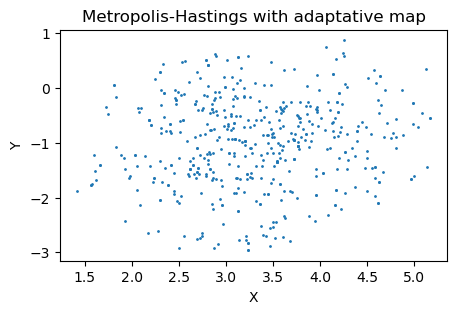

In [62]:
# Parameters for the algorithm
num_samples = 100
num_loop = 5 # not 10 since first loop is done with MH
initial_position = np.array([0, 0])
proposal_covariance = np.array([[0.1, 0], [0, 0.1]])
# Run Metropolis-Hastings
n_samples_MH = 500
first_samples = metropolis_hastings(target_pdf, proposal_distribution, proposal_covariance, n_samples_MH, initial_position)

# Run Metropolis-Hastings with n adaptative transport map
samples = adaptative_transport_mh(first_samples, target_pdf, S, S_inv, reference_proposal, proposal_covariance, num_samples, num_loop)
# Visualize the samples
plt.figure(figsize=(5, 3)) 
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Metropolis-Hastings with adaptative map')
plt.show()

**Observation:** The fixed transport map algorithm demonstrate superior performance compared to the vanilla MH algorithm.  Both MH and adaptative transport MH performed poorly with only 1 000 samples. It's normal that the adptative map performs poorly since the first map is construct over MH samples. However, in real-world scenarios, a fixed transport map may not be available, making the adaptive map version the only feasible option if we want to use transport maps.

Next, we will compare the performance of our primary algorithm, the adaptive transport map MH, with that of the vanilla MH algorithm using a larger sample size. For this comparison, we generated 5,000 samples to observe the ergodic behavior of each algorithm more clearly.

## Comparison after 5 000 samples

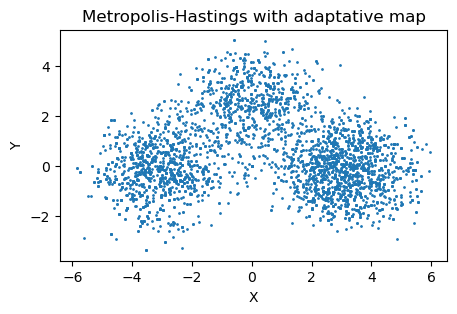

In [9]:
# Parameters for the algorithm
num_samples = 500
num_loop = 9 # not 10 since first loop is done with MH
initial_position = np.array([0, 0])
proposal_covariance = np.array([[0.1, 0], [0, 0.1]])
# Run Metropolis-Hastings
n_samples_MH = 500
first_samples = metropolis_hastings(target_pdf, proposal_distribution, proposal_covariance, n_samples_MH, initial_position)

# Run Metropolis-Hastings with n adaptative transport map
samples = adaptative_transport_mh(first_samples, target_pdf, S, S_inv, reference_proposal, proposal_covariance, num_samples, num_loop)
# Visualize the samples
plt.figure(figsize=(5, 3)) 
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Metropolis-Hastings with adaptative map')
plt.show()

Text(0.5, 1.0, 'Metropolis-Hastings with 5000 samples')

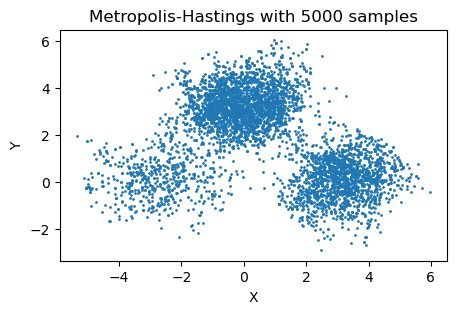

In [58]:
#compare with MH 5000 samples
samples_MH = metropolis_hastings(target_pdf, proposal_distribution, proposal_covariance, 5000, initial_position)
plt.figure(figsize=(5, 3))
plt.scatter(samples_MH[:, 0], samples_MH[:, 1], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Metropolis-Hastings with 5000 samples')

**Observation:** From the results, it appears that the adaptive transport map algorithm has achieved convergence to the distribution using 5,000 samples, while one mode of the mixture appears to be lagging behind with the Metropolis-Hastings algorithm. However, we can see that the samples generated by the new algorithm are sparser compared to the vanilla MH algorithm, which produces samples that are much closer together.We could finetune the proposal covariance to correct this behavior. 

# Conclusion

Adaptive transport maps show potential for improving MCMC efficiency, though solving the optimization problem is computationally intensive. Our experiments didn't utilize parallelization or compare time efficiency. However, as the paper suggests, map update costs should decrease over time. As samples near the true target distribution, parameters converge to the true optimum, making a gradient-based solver's initial guess better for this convex problem.

Careful tuning of parameters, like map update frequency and basis functions, is crucial for successful adaptation. In practive, this tuning can be hard. Moreover, the map estimation relates strongly on samples generated to build them, making this algorithm dependant of non transport MCMC sammples to start with. 

Some possible extensions for transport map MCMC methods could include adaptive basis functions (e.g., wavelets or neural networks) for better accuracy and flexibility, and incorporating domain knowledge to inform the choice of auxiliary distribution or transport map. For example, if the target distribution is known to have certain symmetries or constraints, incorporating this knowledge into the transport map could improve efficiency and accuracy.